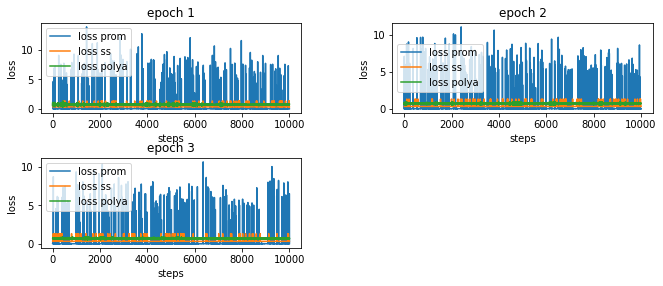

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from visualisation import visualize

log_file = os.path.join("logs", "mtl", "2022-03-22", "log.t-sample.csv")
visualize(log_file)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


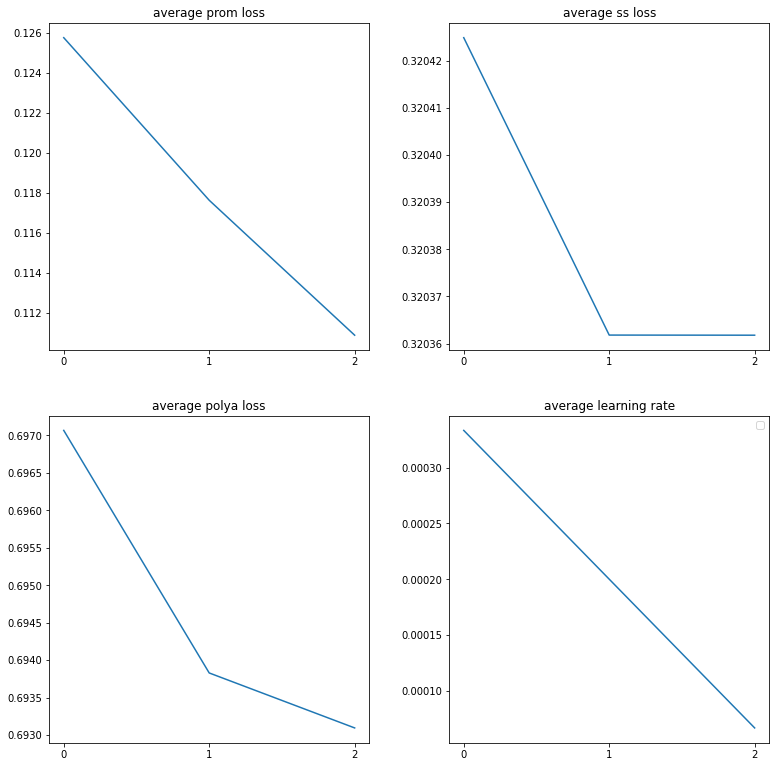

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def visualise_mtl_average_loss(log_path):
    log_df = pd.read_csv(log_path)
    epochs = log_df["epoch"].unique()
    average_prom = []
    average_ss = []
    average_polya = []
    average_lr = []
    for e in epochs:
        df = log_df[log_df["epoch"] == e]
        average_prom.append(df["loss_prom"].mean())
        average_ss.append(df["loss_ss"].mean())
        average_polya.append(df["loss_polya"].mean())
        average_lr.append(df["lr"].mean())
    
    figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    axes[0][0].plot(epochs, average_prom)
    axes[0][0].set_title("average prom loss")
    axes[0][0].set_xticks(epochs)
    axes[0][1].plot(epochs, average_ss)
    axes[0][1].set_title("average ss loss")
    axes[0][1].set_xticks(epochs)
    axes[1][0].plot(epochs, average_polya)
    axes[1][0].set_title("average polya loss")
    axes[1][0].set_xticks(epochs)
    axes[1][1].plot(epochs, average_lr)
    axes[1][1].set_title("average learning rate")
    axes[1][1].set_xticks(epochs)

    plt.subplots_adjust(top=2, bottom=1, left=5, right=6, hspace=0.2, wspace=0.25)
    plt.legend()
    
visualise_mtl_average_loss(os.path.join("logs", "mtl", "2022-03-22", "log.t-sample.csv"))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


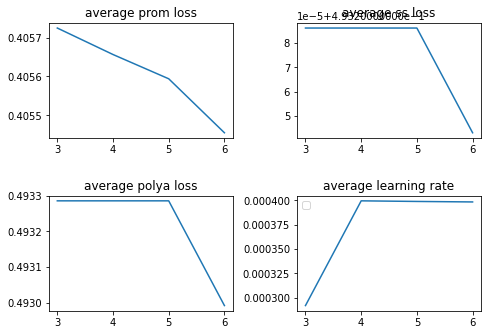

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

log_file = os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.csv")
visualise_mtl_average_loss(log_file)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
log_file1 = os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.1.csv")
log_file2 = os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.2.csv")

df1 = pd.read_csv(log_file1)
df2 = pd.read_csv(log_file2)
df3 = pd.concat([df1, df2])
df3.to_csv(os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.csv"), index=False)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


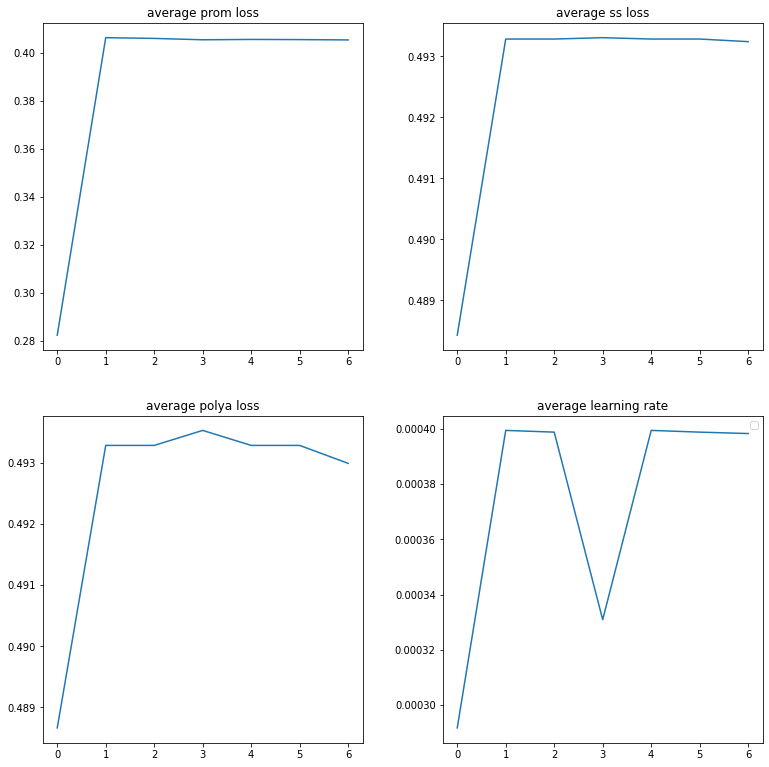

In [22]:
log_file = os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.csv")
visualise_mtl_average_loss(log_file)

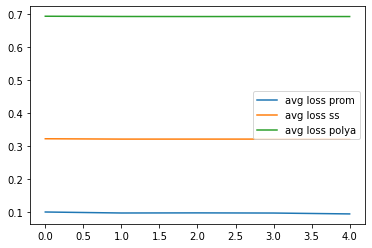

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
def visualize_avg_loss_per_epoch(log_path):
    if not os.path.exists(log_path):
        raise FileNotFoundError("File {} not found.".format(log_path))

    df = pd.read_csv(log_path)
    epochs = list(df['epoch'].unique())
    avg_loss_prom_by_epoch = []
    avg_loss_ss_by_epoch = []
    avg_loss_polya_by_epoch = []
    for e in epochs:
        edf = df[df['epoch'] == e]
        avg_loss_prom_by_epoch.append(edf['loss_prom'].mean())
        avg_loss_ss_by_epoch.append(edf['loss_ss'].mean())
        avg_loss_polya_by_epoch.append(edf['loss_polya'].mean())

    fig, ax = plt.subplots()
    ax.plot(epochs, avg_loss_prom_by_epoch, label="avg loss prom")
    ax.plot(epochs, avg_loss_ss_by_epoch, label="avg loss ss")
    ax.plot(epochs, avg_loss_polya_by_epoch, label="avg loss polya")   
    ax.legend()

    plt.show()

log_dir = os.path.join('logs', '2022-03-05')
log_file = os.path.join(log_dir, 'log_2022-03-05-07-20-19_train.sample.csv_e5_b1_sum.csv')
visualize_avg_loss_per_epoch(log_file)


In [3]:
"""
Create confusion matrix for MTL.
"""
from multitask_learning import init_model_mtl
from data_dir import pretrained_3kmer_dir
from utils.mtl import create_dataloader_from_csv
from transformers import BertTokenizer
import os
from tqdm import tqdm
import torch

model = init_model_mtl(pretrained_3kmer_dir)
model.eval()

tokenizer = BertTokenizer.from_pretrained(pretrained_3kmer_dir)
eval_log = os.path.join("logs", "mtl", "eval", "2022-03-17", "log.csv")
if os.path.exists(eval_log):
    os.remove(eval_log)
os.makedirs(os.path.dirname(eval_log), exist_ok=True)
log = open(eval_log, 'x')
log.write("pred_prom,label_prom,pred_ss,label_ss,pred_polya,label_polya\n")

val_csv = os.path.join("workspace", "mtl", "validation.sample.csv")
dataloader = create_dataloader_from_csv(val_csv, tokenizer, batch_size=1)
for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    input_ids, attn_mask, token_type_ids, label_prom, label_ss, label_polya = tuple(t for t in batch)
    preds = model(input_ids, attn_mask)
    pred_prom = preds["prom"]
    pred_ss = preds["ss"]
    pred_polya = preds["polya"]

    pred_prom_val, pred_prom_index = torch.max(pred_prom, dim=1)
    actual_prom = label_prom.float().item()
    predicted_prom = torch.round(pred_prom_val).item()

    pred_ss_val, pred_ss_index = torch.max(pred_ss, dim=1)
    pred_ss_index = pred_ss_index.item()
    label_ss = label_ss.item()

    pred_polya_val, pred_polya_index = torch.max(pred_polya, dim=1)
    pred_polya_index = pred_polya_index.item()
    label_polya = label_polya.item()
    
    log.write(f"{predicted_prom},{actual_prom},{pred_ss_index},{label_ss},{pred_polya_index},{label_polya}\n")

    #print(pred_prom, pred_prom_index, label_prom)
    #print(pred_ss, pred_ss_index, label_ss)
    #print(pred_polya, pred_polya_index, label_polya)

log.close()

100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


In [4]:
from multitask_learning import evaluate, init_model_mtl
from data_dir import pretrained_3kmer_dir
import torch
import os
from utils.mtl import create_dataloader_from_csv
from transformers import BertTokenizer

summary = {}
tokenizer = BertTokenizer.from_pretrained(pretrained_3kmer_dir)
dataloader = create_dataloader_from_csv(os.path.join("workspace", "mtl", "validation.sample.csv"), tokenizer)
for model_epoch in range(10):
    model = init_model_mtl(pretrained_3kmer_dir)
    model.load_state_dict(torch.load(os.path.join("result", "mtl", "2022-03-17", f"epoch-{model_epoch}.pth")), strict=False)
    model.eval()
    pred_acc, ss_acc, polya_acc = evaluate(model, dataloader, os.path.join("logs", "mtl", "2022-03-17", f"validation.epoch.{model_epoch}.csv"))
    t = (pred_acc, ss_acc, polya_acc)
    summary[f"epoch-{model_epoch}"] = t
summary

Inference: 100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


{'epoch-0': (99.0, 51.0, 0),
 'epoch-1': (99.0, 51.0, 0),
 'epoch-2': (99.0, 51.0, 0),
 'epoch-3': (99.0, 51.0, 0),
 'epoch-4': (99.0, 51.0, 0),
 'epoch-5': (99.0, 51.0, 0),
 'epoch-6': (99.0, 51.0, 0),
 'epoch-7': (99.0, 51.0, 0),
 'epoch-8': (99.0, 51.0, 0),
 'epoch-9': (99.0, 51.0, 0)}

In [3]:
t = (1, 2, 3)
t

(1, 2, 3)

In [5]:
"""
Create confusion matrix.
"""
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
eval_log = os.path.join("logs", "mtl", "eval", "2022-03-17", "log.csv")
df = pd.read_csv(eval_log)
pred_prom = list(df['pred_prom'])
label_prom = list(df['label_prom'])
cf_matrix_prom = confusion_matrix(pred_prom, label_prom)
print(cf_matrix_prom)
pred_ss = list(df['pred_ss'])
label_ss = list(df['label_ss'])
cf_matrix_ss = confusion_matrix(pred_ss, label_ss)
print(cf_matrix_ss)
pred_polya = list(df['pred_polya'])
label_polya = list(df['label_polya'])
cf_matrix_polya = confusion_matrix(pred_polya, label_polya)
print(cf_matrix_polya)


[[98  1]
 [ 1  0]]
[[ 3  5]
 [48 44]]
[[16 11]
 [35 38]]


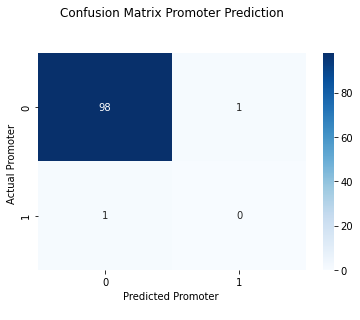

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_prom, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Promoter Prediction\n\n')
ax.set_xlabel('Predicted Promoter \n')
ax.set_ylabel('Actual Promoter ')

## Display the visualization of the Confusion Matrix.
plt.show()

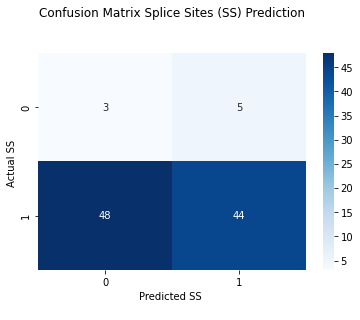

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_ss, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Splice Sites (SS) Prediction\n\n')
ax.set_xlabel('Predicted SS \n')
ax.set_ylabel('Actual SS ')

## Display the visualization of the Confusion Matrix.
plt.show()

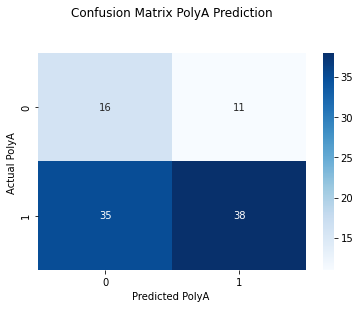

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_polya, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix PolyA Prediction\n\n')
ax.set_xlabel('Predicted PolyA \n')
ax.set_ylabel('Actual PolyA ')

## Display the visualization of the Confusion Matrix.
plt.show()

In [1]:
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

def filter_df_by_epoch(csv_file, epochs):
    results = []
    df = pd.read_csv(csv_file)
    for e in epochs:
        results.append(df[df["epoch"] == e])
    return results

def create_cf_matrix(df):
    predictions = np.array([], int)
    targets = np.array([], int)
    for i, r in tqdm(df.iterrows(), total=df.shape[0], desc="Processing : "):
        target = r["target"].split(' ')
        target = [int(a) for a in target]
        target = np.array(target, int)
        targets = np.concatenate((targets, target))
        prediction = r["prediction"].split(' ')
        prediction = [int(a) for a in prediction]
        prediction = np.array(prediction, int)
        predictions = np.concatenate((predictions, prediction))

    return predictions, targets

def create_confusion_matrix(csv_file, epoch=0):
    # raise NotImplementedError("Function is not implemented.")

    df = pd.read_csv(csv_file)
    df = df[df["epoch"] == epoch]
    predictions = np.array([], int)
    targets = np.array([], int)
    for i, r in tqdm(df.iterrows(), total=df.shape[0], desc="Processing : "):
        target = r["target"].split(' ')
        target = [int(a) for a in target]
        target = np.array(target, int)
        targets = np.concatenate((targets, target))
        prediction = r["prediction"].split(' ')
        prediction = [int(a) for a in prediction]
        prediction = np.array(prediction, int)
        predictions = np.concatenate((predictions, prediction))

    return predictions, targets
            


In [ ]:
seqlab_10_prediction, seqlab_10_target = create_confusion_matrix()

In [ ]:
preds, targets = create_confusion_matrix(os.path.join("run", "seqlab-tiny-base-b64-e50-20220704-215933", "eval_log.csv"))
print(preds.shape)
print(targets.shape)

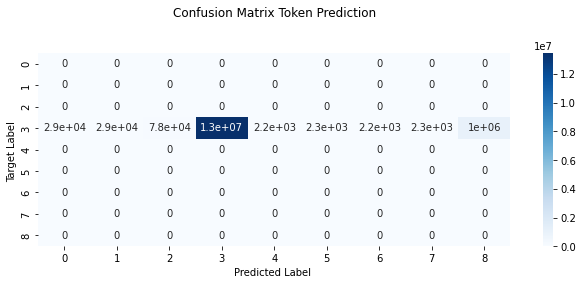

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))

ax = sns.heatmap(
    confusion_matrix(preds, targets)
    , annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Token Prediction\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

In [41]:
dfs = filter_df_by_epoch(os.path.join("run", "seqlab-tiny-base-b64-e50-20220704-215933", "eval_log.csv"),
    [0, 9, 19, 29, 39, 49]
    )

preds0, targets0 = create_cf_matrix(dfs[0]) # After one epoch.
preds9, targets9 = create_cf_matrix(dfs[1]) # After 10 epochs.
preds19, targets19 = create_cf_matrix(dfs[2]) # After 20 epochs.
preds29, targets29 = create_cf_matrix(dfs[3]) # After 30 epochs.
preds39, targets39 = create_cf_matrix(dfs[4]) # After 40 epochs.
preds49, targets49 = create_cf_matrix(dfs[5]) # After 50 epochs.

Processing : 100%|██████████| 28622/28622 [17:53<00:00, 26.66it/s]


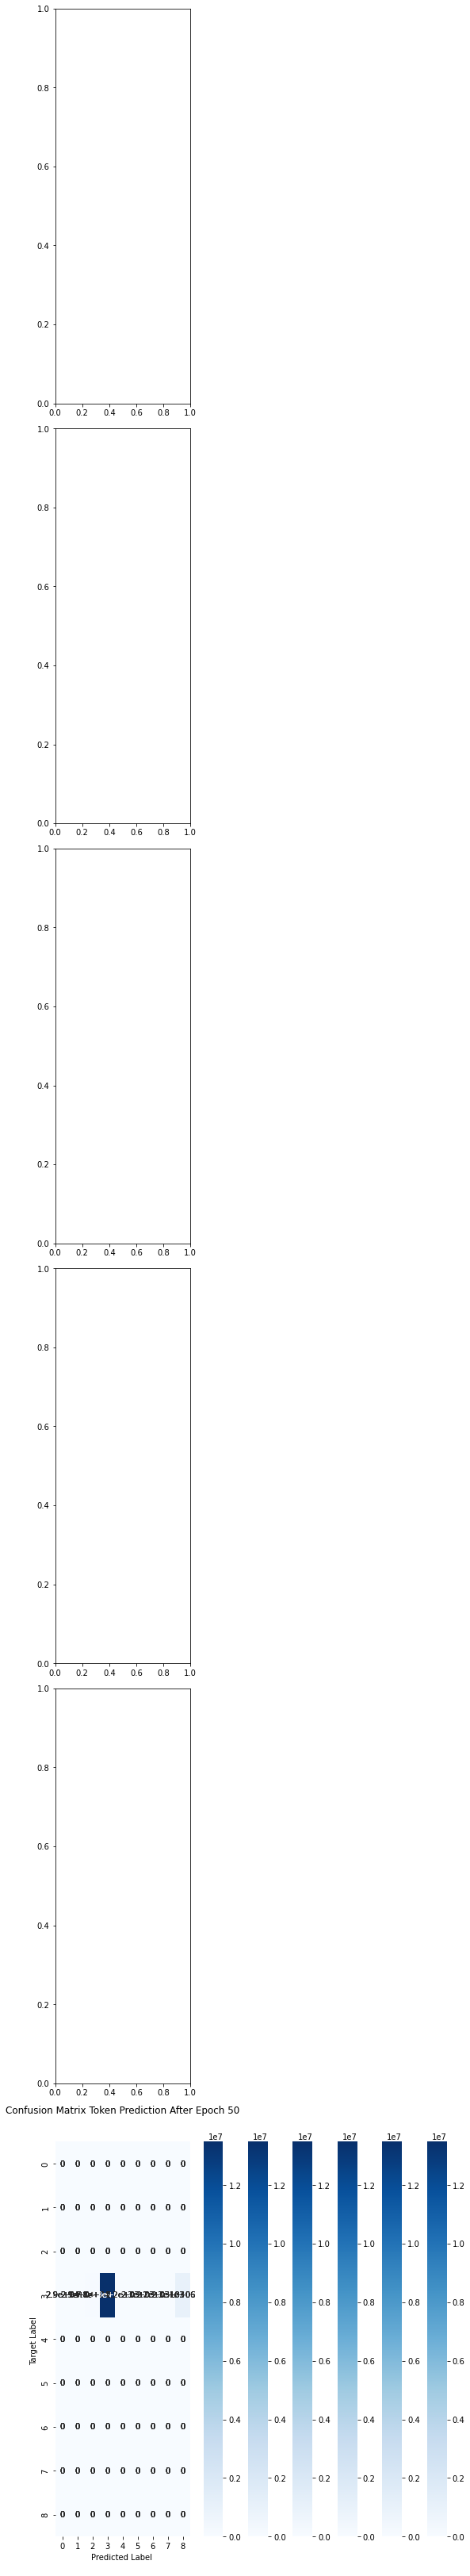

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

figs, axes = plt.subplots(nrows=6, ncols=1, constrained_layout=True)

axes[0] = sns.heatmap(
    confusion_matrix(preds0, targets0)
    , annot=True, cmap='Blues')

axes[0].set_title('Confusion Matrix Token Prediction After First Epoch\n\n')
axes[0].set_xlabel('Predicted Label \n')
axes[0].set_ylabel('Target Label ')

axes[1] = sns.heatmap(
    confusion_matrix(preds9, targets9)
    , annot=True, cmap='Blues')

axes[1].set_title('Confusion Matrix Token Prediction After Epoch 10\n\n')
axes[1].set_xlabel('Predicted Label \n')
axes[1].set_ylabel('Target Label ')

axes[2] = sns.heatmap(
    confusion_matrix(preds19, targets19)
    , annot=True, cmap='Blues')

axes[2].set_title('Confusion Matrix Token Prediction After Epoch 20\n\n')
axes[2].set_xlabel('Predicted Label \n')
axes[2].set_ylabel('Target Label ')

axes[3] = sns.heatmap(
    confusion_matrix(preds29, targets29)
    , annot=True, cmap='Blues')

axes[3].set_title('Confusion Matrix Token Prediction After Epoch 30\n\n')
axes[3].set_xlabel('Predicted Label \n')
axes[3].set_ylabel('Target Label ')

axes[4] = sns.heatmap(
    confusion_matrix(preds39, targets39)
    , annot=True, cmap='Blues')

axes[4].set_title('Confusion Matrix Token Prediction After Epoch 40\n\n')
axes[4].set_xlabel('Predicted Label \n')
axes[4].set_ylabel('Target Label ')


axes[5] = sns.heatmap(
    confusion_matrix(preds49, targets49)
    , annot=True, cmap='Blues')

axes[5].set_title('Confusion Matrix Token Prediction After Epoch 50\n\n')
axes[5].set_xlabel('Predicted Label \n')
axes[5].set_ylabel('Target Label ')

plt.show()




In [15]:
import numpy as np
a = [
    [[1], [2], [3]],
    [[4], [5], [6]]
]
x = np.asarray(a)
print(x.shape)
x = np.squeeze(x, axis=2)
print(x.shape)
print(x)
z = np.squeeze(x[0])
z


(2, 3, 1)
(2, 3)
[[1 2 3]
 [4 5 6]]


array([1, 2, 3])

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_log_seq2seq(log_path):
    log_df = pd.read_csv(log_path)
    epoch = list(log_df['epoch'].unique())
    epochs = [i for i in range(len(epoch))]
    subplot_id = 320
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    for e in epochs:
        e_df = log_df[log_df['epoch'] == e]
        len_e = len(e_df)
        loss = list(e_df['loss'])
        steps = [(k+1) for k in range(0, len_e)]
        subplot_id += 1
        ax = fig.add_subplot(subplot_id)
        ax.plot(steps, loss, label='loss ')
        ax.set_title('epoch {}'.format(e+1))
        ax.set_xlabel('steps')
        ax.set_ylabel('loss')
        ax.legend()
        
    plt.subplots_adjust(top=1.5, bottom=1, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

def visualize_average_epoch_loss(log_path):
    log_df = pd.read_csv(log_path)
    epochs = log_df["epoch"].unique()
    averages = []
    for e in epochs:
        loss_by_epoch_df = log_df[log_df["epoch"] == e]
        average = loss_by_epoch_df["loss"].mean()
        averages.append(average)

    fig = plt.figure()
    subplot_id = 110
    ax = fig.add_subplot(subplot_id + 1)
    ax.plot(epochs, averages)
    ax.set_title("average loss per epoch")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.legend()
    plt.xticks(np.arange(0, len(epochs), step=1))
    plt.subplots_adjust(top=1.5, bottom=1, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()


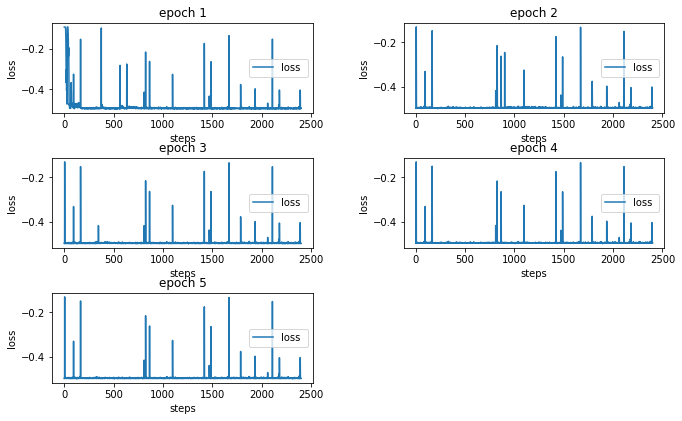

In [4]:
import os
seq2seq_log = os.path.join("logs", "seq2seq", "bundle.sample", "log_e5_b1_g1.csv")
visualize_log_seq2seq(seq2seq_log)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


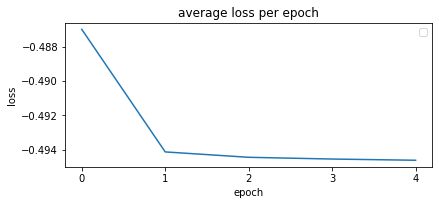

In [44]:
import os
seq2seq_log = os.path.join("logs", "seq2seq", "bundle.sample", "log_e5_b1_g1.csv")
visualize_average_epoch_loss(seq2seq_log)

In [3]:
# Bert Visualization

from bertviz import head_view, model_view
import os
from models.seqlab import DNABERT_SL
from transformers import BertForMaskedLM, BertTokenizer
from utils.seqlab import preprocessing_kmer, _process_label, _process_sequence
import pandas as pd
import torch

bert_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(bert_path)
bert = BertForMaskedLM.from_pretrained(bert_path).bert
model = DNABERT_SL(bert, None)
test_data = os.path.join("workspace", "seqlab", "seqlab.strand-positive.kmer.stride-510.from-index", "sample.csv")
test_dataloader = preprocessing_kmer(test_data, tokenizer, batch_size=1)

In [4]:
test_data_df = pd.read_csv(test_data)
sequence = test_data_df.iloc[0]["sequence"]
label = test_data_df.iloc[0]["label"]
input_ids, attention_mask, token_type_ids = _process_sequence(sequence, tokenizer)
arr_input_ids = []
arr_input_ids.append(input_ids)
arr_input_ids = torch.tensor(arr_input_ids)
arr_attention_mask = []
arr_attention_mask.append(attention_mask)
arr_attention_mask = torch.tensor(arr_attention_mask)
label_ids = _process_label(label)
pred, bert_output = model(arr_input_ids, arr_attention_mask)



In [5]:
attention = bert_output[-1]
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)
print(attention)

['[CLS]', 'GAG', 'AGA', 'GAT', 'ATT', 'TTT', 'TTT', 'TTC', 'TCC', 'CCT', 'CTG', 'TGC', 'GCA', 'CAG', 'AGC', 'GCA', 'CAG', 'AGC', 'GCT', 'CTC', 'TCA', 'CAG', 'AGT', 'GTC', 'TCT', 'CTA', 'TAC', 'ACT', 'CTA', 'TAC', 'ACA', 'CAT', 'ATT', 'TTT', 'TTT', 'TTC', 'TCT', 'CTA', 'TAG', 'AGA', 'GAA', 'AAG', 'AGT', 'GTC', 'TCT', 'CTG', 'TGC', 'GCT', 'CTA', 'TAA', 'AAA', 'AAT', 'ATA', 'TAA', 'AAT', 'ATT', 'TTT', 'TTT', 'TTT', 'TTT', 'TTT', 'TTA', 'TAA', 'AAG', 'AGT', 'GTT', 'TTT', 'TTT', 'TTC', 'TCA', 'CAT', 'ATT', 'TTG', 'TGA', 'GAA', 'AAA', 'AAT', 'ATT', 'TTT', 'TTA', 'TAA', 'AAC', 'ACA', 'CAA', 'AAC', 'ACA', 'CAT', 'ATA', 'TAG', 'AGA', 'GAT', 'ATA', 'TAT', 'ATA', 'TAG', 'AGA', 'GAA', 'AAA', 'AAA', 'AAC', 'ACC', 'CCA', 'CAT', 'ATA', 'TAC', 'ACT', 'CTG', 'TGA', 'GAT', 'ATG', 'TGG', 'GGA', 'GAC', 'ACC', 'CCT', 'CTT', 'TTT', 'TTG', 'TGA', 'GAA', 'AAG', 'AGT', 'GTT', 'TTT', 'TTT', 'TTG', 'TGT', 'GTT', 'TTT', 'TTC', 'TCC', 'CCA', 'CAA', 'AAC', 'ACT', 'CTA', 'TAA', 'AAT', 'ATC', 'TCT', 'CTC', 'TCA', 'CA

In [5]:
head_view(attention, tokens, -1)

In [47]:
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

model_version = os.path.join('pretrained', 'bert-base-uncased')
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 


In [50]:
sentence_b_start
attention
tokens

['[CLS]',
 'the',
 'cat',
 'sat',
 'on',
 'the',
 'mat',
 '[SEP]',
 'the',
 'cat',
 'lay',
 'on',
 'the',
 'rug',
 '[SEP]']

In [49]:
head_view(attention, tokens, sentence_b_start)


<IPython.core.display.Javascript object>

In [49]:
import utils.seqlab

utils.seqlab.NUM_LABELS

8